In [1]:
import numpy as np 
import os
import time
import math
from functools import partial
import torch
from tqdm import tqdm

os.chdir('/home/bala/Desktop/sri_krishna/SEG-rc')

In [2]:
file = "results/metrics/77/gaussian_7_10/segAppliedLayers-['mid']__blurTimeRegions-['begin']/segScale-3_guidanceScale-0/steps-30___block-mid.pkl"

import pickle
with open(file, "rb") as f:
    data = pickle.load(f)
    print(data[1])

[{'l2_norm': 910.2921752929688, 'laplacian_variance': 22082.126137770563, 'gradient_entropy': 8.810246467590332}, {'l2_norm': 911.0709838867188, 'laplacian_variance': 21801.937470458568, 'gradient_entropy': 8.806278228759766}, {'l2_norm': 912.0896606445312, 'laplacian_variance': 21913.980825999897, 'gradient_entropy': 8.805559158325195}, {'l2_norm': 914.213134765625, 'laplacian_variance': 21867.643906005273, 'gradient_entropy': 8.803642272949219}, {'l2_norm': 916.8643188476562, 'laplacian_variance': 21870.34932996339, 'gradient_entropy': 8.802240371704102}, {'l2_norm': 919.4467163085938, 'laplacian_variance': 21876.47266061376, 'gradient_entropy': 8.802286148071289}, {'l2_norm': 921.3214111328125, 'laplacian_variance': 22048.917203651876, 'gradient_entropy': 8.804308891296387}, {'l2_norm': 923.022705078125, 'laplacian_variance': 21429.03404977449, 'gradient_entropy': 8.797812461853027}, {'l2_norm': 926.3756103515625, 'laplacian_variance': 20912.86732034756, 'gradient_entropy': 8.792580

# Speed Comparison
#### (Gaussian blur vs EMA)

BoxBlur...: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


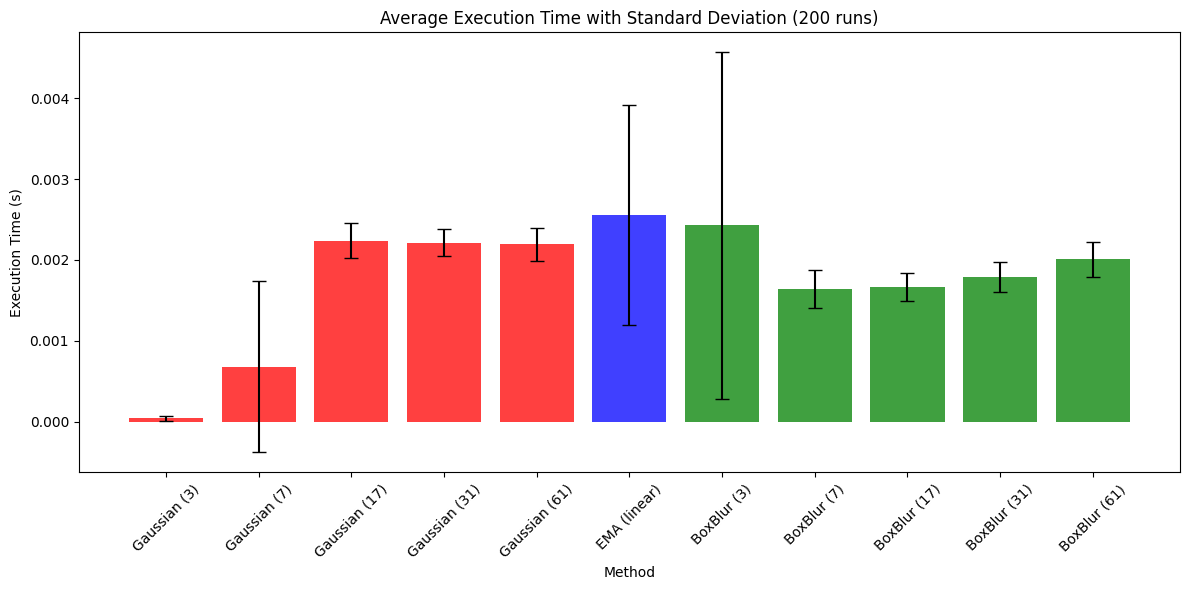

In [7]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from diffusion_utils.blur import gaussian_blur_2d, interpolated_box_blur, ema_vectorized
import json 
import gc
# Create a fixed tensor for testing; e.g., shape (batch, channels, height, width)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tensor = torch.randn(3, 20, 1024, 64, dtype=torch.float64).to(device)

# Number of runs for averaging
num_runs = 200

# Set sigma for the Gaussian blur.
sigma = 10

# ---------------------
# Gaussian Blur Timing
# ---------------------
kernel_sizes = [3, 7, 17, 31, 61]
gaussian_means = []
gaussian_stds = []

gc.collect()
for kernel in tqdm(kernel_sizes, desc = "GaussianBlur..."):
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        _ = gaussian_blur_2d(tensor, sigma, kernel)
        elapsed = time.time() - start_time
        times.append(elapsed)
    
    gaussian_means.append(np.mean(times))
    gaussian_stds.append(np.std(times))

# ---------------------
# EMA Smoothing Timing
# ---------------------
modes = ["linear"]
ema_means = []
ema_stds = []
gc.collect()
for mode in tqdm(modes, desc = "EMA..."):
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        # _ = ema_smoothing_time_dependent(query=tensor, alpha_fn=alpha_fn)
        _ = ema_vectorized(tensor, 0.9)
        elapsed = time.time() - start_time
        times.append(elapsed)
    
    ema_means.append(np.mean(times))
    ema_stds.append(np.std(times))

# ---------------------
# Interpolated BoxBlur Timing
# ---------------------
kernel_sizes = [3, 7, 17, 31, 61]
alpha = 0.9
box_blur_means = []
box_blur_stds = []

for kernel_size in tqdm(kernel_sizes, desc = "BoxBlur..."):
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        _ = interpolated_box_blur(tensor, kernel_size, alpha)
        elapsed = time.time() - start_time
        times.append(elapsed)
    
    box_blur_means.append(np.mean(times))
    box_blur_stds.append(np.std(times))

speed_metrics = {
    'gaussian': (gaussian_means, gaussian_stds),
    'ema': (ema_means, ema_stds),
    'box_blur': (box_blur_means, box_blur_stds)
}
json.dump(speed_metrics, open(f"speed_metrics_{device}.json", "w"))

# ---------------------
# Combine and Plot Results with Error Bars
# ---------------------
x_labels = (
    [f"Gaussian ({k})" for k in kernel_sizes] +
    [f"EMA ({m})" for m in modes] +
    [f"BoxBlur ({k})" for k in kernel_sizes]
)
means = gaussian_means + ema_means + box_blur_means
stds = gaussian_stds + ema_stds + box_blur_stds
colors = (['red'] * len(gaussian_means) + ['blue'] * len(ema_means) + ['green'] * len(box_blur_means))

plt.figure(figsize=(12, 6))
plt.bar(x_labels, means, yerr=stds, color=colors, capsize=5, alpha=0.75)
plt.xlabel("Method")
plt.ylabel("Execution Time (s)")
plt.title(f"Average Execution Time with Standard Deviation ({num_runs} runs)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

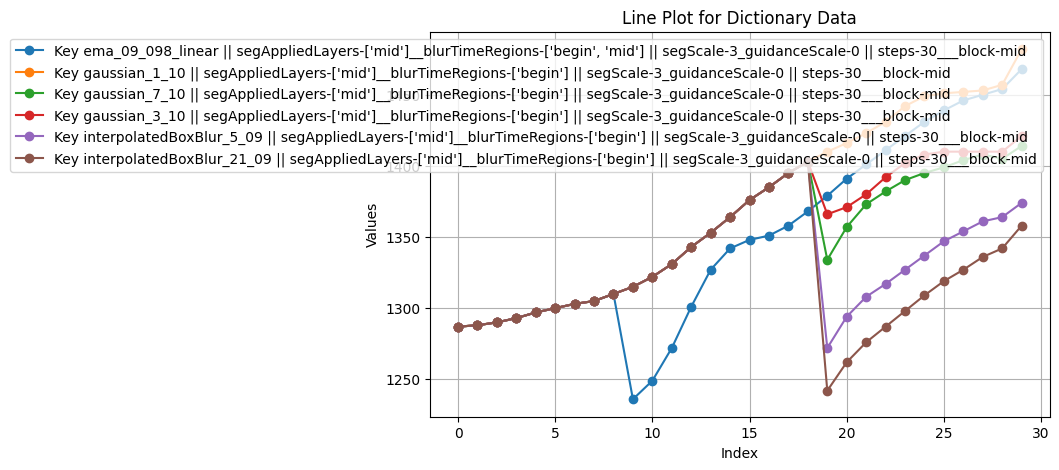

In [22]:

import matplotlib.pyplot as plt
import pickle 

def plot_metric(data):
    
    # Plot each key's values as a separate line
    plt.figure(figsize=(8, 5))
    for key, values in data.items():
        plt.plot(range(len(values)), values, marker='o', label=f"Key {key}")

    # Labels and title
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.title("Line Plot for Dictionary Data")
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()
    
    
files=[
    "results/metrics/77/ema_0.9_0.98_linear/segAppliedLayers-['mid']__blurTimeRegions-['begin', 'mid']/segScale-3_guidanceScale-0/steps-30___block-mid.pkl", 
    "results/metrics/77/gaussian_1_10/segAppliedLayers-['mid']__blurTimeRegions-['begin']/segScale-3_guidanceScale-0/steps-30___block-mid.pkl" ,
    "results/metrics/77/gaussian_7_10/segAppliedLayers-['mid']__blurTimeRegions-['begin']/segScale-3_guidanceScale-0/steps-30___block-mid.pkl" ,
    "results/metrics/77/gaussian_3_10/segAppliedLayers-['mid']__blurTimeRegions-['begin']/segScale-3_guidanceScale-0/steps-30___block-mid.pkl" ,
    "results/metrics/77/interpolatedBoxBlur_5_0.9/segAppliedLayers-['mid']__blurTimeRegions-['begin']/segScale-3_guidanceScale-0/steps-30___block-mid.pkl", 
    "results/metrics/77/interpolatedBoxBlur_21_0.9/segAppliedLayers-['mid']__blurTimeRegions-['begin']/segScale-3_guidanceScale-0/steps-30___block-mid.pkl" , 
]
block_1_data = {}
for file in files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
    key = "".join(" || ".join(file.split('/')[3:]).split('.')[:-1])
    block_1_data[key] = data[1]
    
plot_metric(block_1_data)